In [68]:
# NOTE: has to be done in python 2.7 as python 3 currently not supported by the fitparse package
import numpy as np
import glob
import re
import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import fitparse
# for plotting on Google maps
import gmplot
from scipy.signal import savgol_filter
from collections import OrderedDict
%matplotlib inline

In [2]:
filenames = glob.glob('Gary_run_*.fit')
print len(filenames)
print filenames[0]

20
Gary_run_030218.fit


In [3]:
dataframe_dict = {}
for f in filenames:
    run_date = re.findall('\d{6}', f)[0]
    fitfile = fitparse.FitFile(f)
    # Create dataframe from records in list
    record_df_list = [pd.concat([pd.DataFrame([record_data.value], columns=[record_data.name]) for record_data in record], axis=1) \
    for record in fitfile.get_messages('record')]
    df = pd.concat(record_df_list, ignore_index=True)
    # Clean up dataframe
    #df['activity_type'] = df['activity_type'].astype('category')
    df = df.drop(labels=['enhanced_altitude', 'enhanced_speed'], axis=1)
    # Convert lon, lat
    df['position_lat'] = df['position_lat'] * (180. / 2**31)
    df['position_long'] = df['position_long'] * (180. / 2**31)
    # Add to dictionary, with date as key
    dataframe_dict[run_date] = df

Probably want to drop unnecessary columns from dataframes in the for loop above so that less information is held in memory

In [4]:
dataframe_dict['061117'].head()

,activity_type,altitude,cadence,distance,fractional_cadence,heart_rate,position_lat,position_long,speed,stance_time,stance_time_balance,stance_time_percent,step_length,timestamp,unknown_61,unknown_66,vertical_oscillation,vertical_ratio
0,running,141.0,84,0.00,0.5,72,53.650016,-1.804412,1.372,268.0,54.40,37.50,567.0,2017-11-06 18:18:28,3177,425,103.5,20.40
1,running,141.2,85,7.35,0.5,75,53.650081,-1.804397,1.847,263.0,52.78,37.25,773.0,2017-11-06 18:18:31,3177,424,85.7,12.87
2,running,141.0,86,10.23,0.0,81,53.650107,-1.804392,1.885,259.0,52.37,37.00,768.0,2017-11-06 18:18:32,3176,424,87.7,12.50
3,running,141.0,86,13.33,0.0,81,53.650135,-1.804389,1.931,254.0,52.00,36.00,801.0,2017-11-06 18:18:33,3176,424,88.7,11.90
4,running,141.2,83,21.27,0.5,88,53.650204,-1.804410,2.025,263.0,52.15,37.00,926.0,2017-11-06 18:18:36,3177,424,95.5,10.81


In [5]:
for key, dframe in dataframe_dict.iteritems():
    print key
    print dframe.info()

100218
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692 entries, 0 to 691
Data columns (total 18 columns):
activity_type           692 non-null object
altitude                692 non-null float64
cadence                 692 non-null int64
distance                692 non-null float64
fractional_cadence      692 non-null float64
heart_rate              692 non-null int64
position_lat            692 non-null float64
position_long           692 non-null float64
speed                   692 non-null float64
stance_time             692 non-null float64
stance_time_balance     692 non-null float64
stance_time_percent     692 non-null float64
step_length             692 non-null float64
timestamp               692 non-null datetime64[ns]
vertical_oscillation    692 non-null float64
vertical_ratio          692 non-null float64
unknown_61              692 non-null int64
unknown_66              692 non-null int64
dtypes: datetime64[ns](1), float64(12), int64(4), object(1)
memory usage: 97.4+ 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594 entries, 0 to 593
Data columns (total 18 columns):
activity_type           592 non-null object
altitude                594 non-null float64
cadence                 594 non-null int64
distance                594 non-null float64
fractional_cadence      594 non-null float64
heart_rate              594 non-null int64
position_lat            594 non-null float64
position_long           594 non-null float64
speed                   594 non-null float64
stance_time             587 non-null float64
stance_time_balance     587 non-null float64
stance_time_percent     587 non-null float64
step_length             592 non-null float64
timestamp               594 non-null datetime64[ns]
unknown_61              594 non-null int64
unknown_66              594 non-null int64
vertical_oscillation    592 non-null float64
vertical_ratio          592 non-null float64
dtypes: datetime64[ns](1), float64(12), int64(4), object(1)
memory usage: 83.6+ KB
None

We can see that the individual dataframes contain only a small percentage of null values, so can just remove these.

Also, dataframe '281217' seems to be missing a lot of the columns for some reason, so it's best to remove this one

In [6]:
del dataframe_dict['281217']

In [7]:
for key, dframe in dataframe_dict.iteritems():
    dframe = dframe.dropna()
    dataframe_dict[key] = dframe.reset_index(drop=True)

Now convert the dict keys to datetime objects so that the dataframes can be sorted in order of oldest to most recent

In [8]:
dataframe_dict_dates = {}
for key, dframe in dataframe_dict.iteritems():
    key_new = datetime.date(int(key[4:]), int(key[2:4]), int(key[:2]))
    dataframe_dict_dates[key_new] = dframe
    
dataframe_dict_sorted = OrderedDict(sorted(dataframe_dict_dates.items()))
print dataframe_dict_sorted.keys()

[datetime.date(17, 10, 8), datetime.date(17, 10, 14), datetime.date(17, 10, 18), datetime.date(17, 10, 21), datetime.date(17, 10, 24), datetime.date(17, 10, 28), datetime.date(17, 11, 6), datetime.date(17, 11, 20), datetime.date(17, 11, 26), datetime.date(17, 12, 6), datetime.date(17, 12, 17), datetime.date(18, 1, 14), datetime.date(18, 1, 18), datetime.date(18, 1, 25), datetime.date(18, 1, 27), datetime.date(18, 2, 3), datetime.date(18, 2, 10), datetime.date(18, 2, 13), datetime.date(18, 2, 20)]


# Heatmap

First just use the gmplot package to plot a heatmap onto Google maps. There's not much flexibility here though

In [10]:
# Create gmplot instance with location of map centre and zoom level (1 - 20)
gmap = gmplot.GoogleMapPlotter(np.mean(dataframe_dict['030218']['position_lat']),
                               np.mean(dataframe_dict['030218']['position_long']), 13)

latitudes_all = np.array([])
longitudes_all = np.array([])
for key, dframe in dataframe_dict.iteritems():
    latitudes_all = np.append(latitudes_all, dframe['position_lat'])
    longitudes_all = np.append(longitudes_all, dframe['position_long'])
gmap.heatmap(latitudes_all, longitudes_all)
    
gmap.draw("Gary_run_multi_heatmap.html")

Now create a heatmap from scratch. This can use a 2D histogram, or the hexagonal binning method hexbin:

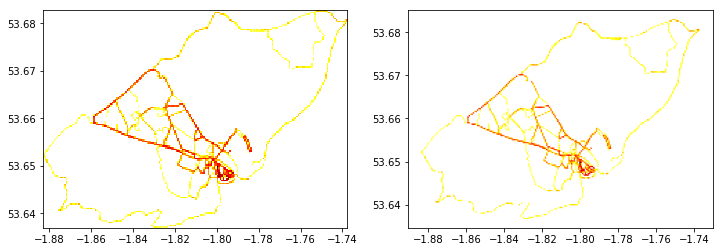

In [63]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
hist_raw = plt.hist2d(longitudes_all, latitudes_all, bins=(200, 140), norm=colors.LogNorm(), cmap='hot_r')
plt.subplot(1, 2, 2)
plt.hexbin(longitudes_all, latitudes_all, gridsize=(200, 140), bins='log', cmap='hot_r')
plt.show()

An advantage of the 2D histogram is that we can take the binned data and manually apply some smoothing:

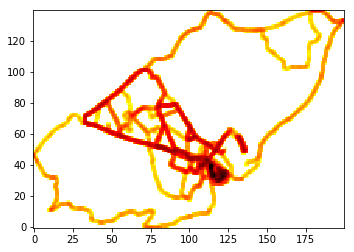

In [87]:
hist_smooth = savgol_filter(hist_raw[0], window_length=3, polyorder=1, axis=0)
hist_smooth = savgol_filter(hist_smooth, window_length=3, polyorder=1, axis=1)
plt.imshow(hist_smooth.T, interpolation='none', cmap='hot_r', origin='lower', norm=colors.LogNorm())
plt.show()